# Deep Gaussian Process

### Author: Mark Pullin

This notebooks demonstrates the use of deep Gaussian processes in MXFusion for regression. The model is based on the [Doubly Stochastic Variational Inference for Deep Gaussian Processes (Hugh Salimbeni, Marc Deisenroth)](https://arxiv.org/abs/1705.08933) paper.

This notebook fits the model to a step function.

In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
FIG_SIZE = (12, 8)

import mxfusion
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

# Generate training data

In [2]:
import numpy as np
N = 50
X = np.linspace(-1, 1, N)[:, None]
Y = (X > 0).astype(float)

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=FIG_SIZE)
plt.title('Step Function')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(X, Y);

# Make DGP model

In [4]:
import mxnet as mx
import mxfusion.components.distributions.gp.kernels
from mxfusion.components.variables import PositiveTransformation
from mxfusion.modules.gp_modules.dgp import DeepGPRegression
from mxfusion.components.distributions.gp.kernels import RBF

def make_dgp_model(n_dimensions, n_inducing):
    """
    Makes a DGP model with specified latent dimensions with RBF kernels at each layer
    """
    layer_input_dimensions = n_dimensions[:-1]
    layer_output_dimensions = n_dimensions[1:]
    
    m = mxfusion.Model()
    m.N = mxfusion.Variable()
    
    n_layers = len(layer_input_dimensions)
    m.X = mxfusion.Variable(shape=(m.N, n_dimensions[0]))
    kernels = []
    for i in range(n_layers):
        M = n_inducing[i]
        kernels.append(RBF(layer_input_dimensions[i], lengthscale=0.1))
        z_locations = np.linspace(-1, 1, M)[:, None]
        setattr(m, 'Z_' + str(i), mxfusion.Variable(shape=(M, layer_input_dimensions[i]), 
                                                    initial_value=mx.nd.array(z_locations)))
        
    m.noise_var = mxfusion.Variable(transformation=PositiveTransformation())
    inducing_variables = [getattr(m, 'Z_' + str(i)) for i in range(n_layers)]
    m.Y = DeepGPRegression.define_variable(m.X, kernels, m.noise_var, shape=(m.N, n_dimensions[-1]), 
                                           inducing_inputs=inducing_variables, n_samples=10)
    
    return m

M = 10
n_layers = 2
n_inducing = [10, 10]
m = make_dgp_model([1, 1, 1], n_inducing)

# Create inference object

In [5]:
from mxfusion.inference import GradBasedInference, MAP
infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))

# Initialize variational distribution at each layer

In [6]:
def initialise_model(m, infr):
    """
    Initializes mean of variational distribution at inducing points to be identity function
    """
    dtype = 'float64'
    infr.initialize(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'))
    for i in range(n_layers):
        mean = getattr(m.Y.factor._extra_graphs[0], 'qU_mean_' + str(i))
        inducing_locations = getattr(m.Y.factor._module_graph, 'inducing_inputs_' + str(i))
        
        input_dim = infr.params[inducing_locations].shape[1]
        output_dim = infr.params[mean].shape[0]
        if input_dim == output_dim:
            infr.params[mean] = infr.params[inducing_locations].T
        elif input_dim > output_dim:
            inducing_locs = infr.params[inducing_locations].T
            _, _, v = np.linalg.svd(inducing_locs.asnumpy(), full_matrices=False)
            infr.params[mean] = mx.nd.array(v[:output_dim, :])
        else:
            # output_dim > input_dim
            inducing_locations_array = infr.params[inducing_locations]
            n_inducing = inducing_locations_array.shape[0]
            padding_array = mx.nd.zeros((output_dim - input_dim, n_inducing), dtype=dtype)
            infr.params[mean] = mx.nd.concatenate([inducing_locations_array.T, padding_array], axis=0)
    infr.params[m.noise_var] = mx.nd.array([1e-3])
initialise_model(m, infr)
m.Y.factor.dgp_log_pdf.jitter = 1e-6

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


# Train model

In [7]:
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=500, learning_rate=0.05, verbose=True)
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=500, learning_rate=0.01, verbose=True)

/Users/marpulli/git/MXFusion/mxfusion/inference/inference.py:155: UserWarning: Trying to initialize the inference twice, skipping.
  warnings.warn("Trying to initialize the inference twice, skipping.")


Iteration 51 loss: 1986.4689207046292
Iteration 101 loss: 783.3530167042188
Iteration 151 loss: 314.03553142454984
Iteration 201 loss: 192.83780466342483
Iteration 251 loss: 103.11683785040182
Iteration 301 loss: 71.673705787460014
Iteration 351 loss: 39.902957128958286
Iteration 401 loss: 30.357376420330574
Iteration 451 loss: 15.898671843314014
Iteration 51 loss: -14.374276982010336
Iteration 101 loss: -20.388782771904808
Iteration 151 loss: -26.363782523846714
Iteration 201 loss: -32.369966580485205
Iteration 251 loss: -36.498388851860425
Iteration 301 loss: -45.792660237672954
Iteration 351 loss: -50.660808925114914
Iteration 401 loss: -58.984621903649455
Iteration 451 loss: -61.447187209571076
Iteration 500 loss: -69.018505127811325

# Plot model

In [12]:
def predict(model, infr, inputs, start_layer, final_layer):
    """
    Propogates inputs from start_layer to final_layer
    """
    
    m.Y.factor.dgp_predict.n_samples = 1000
    m.Y.factor.dgp_predict.prediction_layer = final_layer
    m.Y.factor.dgp_predict.start_layer = start_layer
    infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                                  infr_params=infr.params)
    res = infr_pred.run(X=mx.nd.array(inputs, dtype='float64'))[0]
    f_mean, f_var = res[0].asnumpy(), res[1].asnumpy()
    return f_mean.mean(axis=0)[:, 0], f_var.mean(axis=0)[:, 0]

In [13]:
import matplotlib.pyplot as plt
def plot_predictions():
    xt = np.linspace(-2, 2, 250)[:, None]

    # More samples to give smoother plots
    f_mean, f_var = predict(m, infr, xt, 0, n_layers)
    std = np.sqrt(f_var)
    
    plt.figure(figsize=(12, 8))
    plt.plot(xt, f_mean)
    plt.fill_between(xt[:, 0], f_mean - std, f_mean + std, alpha=0.1)

In [14]:
import matplotlib.pyplot as plt
from mxfusion.util.customop import make_diagonal
from mxfusion.modules.gp_modules.dgp import predict_from_layer

from mxfusion.inference import ModulePredictionAlgorithm, TransferInference

def plot_layer(layer):
    xt = np.linspace(-2, 2, 250)[:, None]

    # More samples to give smoother plots
    f_mean, f_var = predict(m, infr, xt, layer-1, layer)
    std = np.sqrt(f_var)
    
    plt.figure(figsize=(12, 8))
    plt.plot(xt, f_mean)
    plt.fill_between(xt[:, 0], f_mean - std, f_mean + std, alpha=0.1)

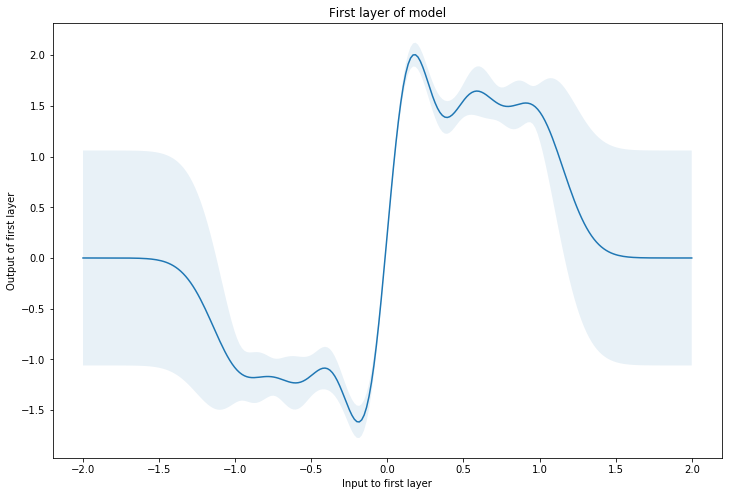

In [15]:
plot_layer(1)
plt.title('First layer of model')
plt.ylabel('Output of first layer')
plt.xlabel('Input to first layer');

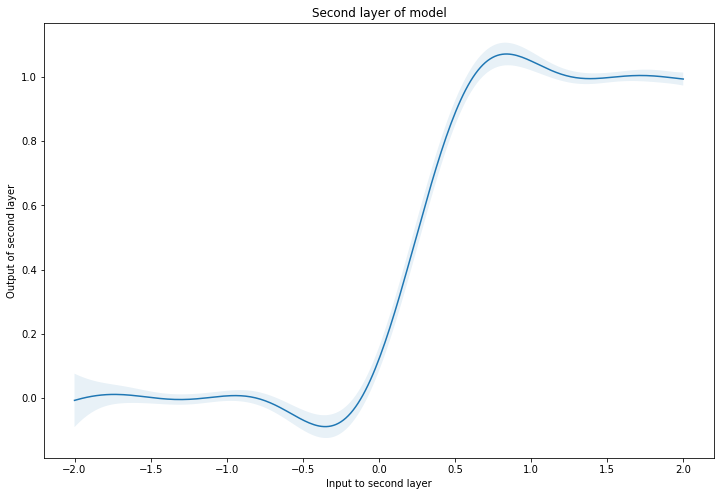

In [16]:
plot_layer(2)
plt.title('Second layer of model')
plt.ylabel('Output of second layer')
plt.xlabel('Input to second layer');

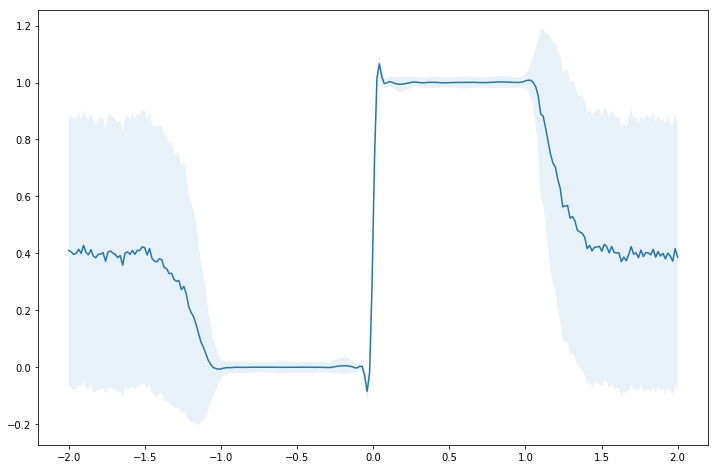

In [17]:
plot_predictions()